In [1]:
import pandas as pd
import numpy as np
import logging
import time 
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, random_split

from scipy.spatial import distance

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tqdm import tqdm
import pickle

/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.default_rng(seed=42)
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [3]:
df_train = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/paired_embedded_train_data_biolincc.pkl")
df_test = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/paired_embedded_test_data_biolincc.pkl")

In [4]:
print(df_train.shape, df_test.shape)

(47000, 10) (11890, 10)


### Dataset Creation

In [5]:
tr_input1 = torch.tensor([x[0].numpy() for x in df_train[['biobert_embedding_1']].to_numpy()])
tr_input2 = torch.tensor([x[0].numpy() for x in df_train[['biobert_embedding_2']].to_numpy()])
tr_targets = torch.tensor([x for x in df_train[['match']].to_numpy()]).to(torch.float32)
tr_idx = torch.tensor([x for x in df_train[['idx']].to_numpy()])
batch_size = 5000
te_input1 = torch.tensor([x[0].numpy() for x in df_test[['biobert_embedding_1']].to_numpy()])
te_input2 = torch.tensor([x[0].numpy() for x in df_test[['biobert_embedding_2']].to_numpy()])
te_targets = torch.tensor([x for x in df_test[['match']].to_numpy()]).to(torch.float32)
te_idx = torch.tensor([x for x in df_test[['idx']].to_numpy()])

tr_dataset = TensorDataset(tr_idx, tr_input1, tr_input2, tr_targets)
te_dataset = TensorDataset(te_idx, te_input1, te_input2, te_targets)
train_data, val_data = random_split(tr_dataset, [38000, 9000])
test_data, _ = random_split(te_dataset, [11880, 10])
train_loader = DataLoader(train_data, batch_size)
val_loader = DataLoader(val_data, batch_size)
test_loader = DataLoader(test_data, batch_size)

/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  """Entry point for launching an IPython kernel.


In [6]:
print(len(tr_idx), len(te_idx))

47000 11890


### Model Creation

In [7]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        
        self.first_layer = nn.Linear(768, 256) 
        # also add a dropout layer (10%) after initial tests without
        self.relu = nn.ReLU()
        self.second_layer = nn.Linear(256, 128)
        self.cosine = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.sigmoid = nn.Sigmoid()
        self.bias = nn.Parameter(torch.rand(1, 1))

    def forward(self, inp1, inp2):
        hidden_first_1 = self.first_layer(inp1)
        hidden_first_2 = self.first_layer(inp2)
        hidden_second_1 = self.second_layer(self.relu(hidden_first_1))
        hidden_second_2 = self.second_layer(self.relu(hidden_first_2))
        similarity = self.cosine(hidden_second_1, hidden_second_2) + self.bias
        output = self.sigmoid(similarity)
        return output.T

In [8]:
model = FCN()

### Training

In [9]:
# init loss lists
train_loss_history = []
val_loss_history = []

In [10]:
# init index trackers
train_idx_tracker = []
val_idx_tracker = []

In [11]:
# set training hyperparameters
num_epochs = 500
patience = 5
min_val_delta = 0

In [12]:
if torch.cuda.is_available():
    model = model.to('cuda')

model.train()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
early_stopping_counter = 0
min_val_loss = np.inf

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_val_loss = 0
    
    # compute train loss for epoch and step through
    for batch in train_loader:
        optimizer.zero_grad()
        
        idx, inp1, inp2, label = batch
        train_idx_tracker.append(idx.cpu().squeeze().detach().numpy())
        
        if torch.cuda.is_available():
            inp1 = inp1.to('cuda')
            inp2 = inp2.to('cuda')
            label = label.to('cuda')

        output = model(inp1, inp2)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.cpu().item()
    
    # compute val loss for epoch
    with torch.no_grad():
        for val_batch in val_loader:
                val_idx, val_inp1, val_inp2, val_label = val_batch
                val_idx_tracker.append(val_idx.cpu().squeeze().detach().numpy())
                
                if torch.cuda.is_available():
                    val_inp1 = val_inp1.to('cuda')
                    val_inp2 = val_inp2.to('cuda')
                    val_label = val_label.to('cuda')

                val_output = model(val_inp1, val_inp2)
                val_loss = criterion(val_output, val_label)
                epoch_val_loss += val_loss.cpu().item()
    
    # print to log
    if (epoch % 20 == 0) and (epoch >= 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    elif (epoch % 5 == 0) and (epoch < 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    
    # add loss to histories
    train_loss_history.append(epoch_loss)
    val_loss_history.append(epoch_val_loss)
    
    # set early stopping
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        early_stopping_counter = 0
    elif epoch_val_loss > (min_val_loss + min_val_delta):
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Initiating early stopping at epoch %d." % (epoch))
            break

Epoch 0 	 Train Loss 6.854525 	 Val Loss 1.517558
Epoch 5 	 Train Loss 5.579090 	 Val Loss 1.394688
Epoch 10 	 Train Loss 5.387148 	 Val Loss 1.356530
Epoch 15 	 Train Loss 5.249687 	 Val Loss 1.326564
Epoch 20 	 Train Loss 5.131622 	 Val Loss 1.300512
Epoch 40 	 Train Loss 4.734597 	 Val Loss 1.210446
Epoch 60 	 Train Loss 4.417070 	 Val Loss 1.132385
Epoch 80 	 Train Loss 4.150425 	 Val Loss 1.068077
Epoch 100 	 Train Loss 3.935534 	 Val Loss 1.013047
Epoch 120 	 Train Loss 3.759775 	 Val Loss 0.969340
Epoch 140 	 Train Loss 3.621271 	 Val Loss 0.932530
Epoch 160 	 Train Loss 3.508484 	 Val Loss 0.902209
Epoch 180 	 Train Loss 3.420389 	 Val Loss 0.879535
Epoch 200 	 Train Loss 3.354029 	 Val Loss 0.861613
Epoch 220 	 Train Loss 3.303409 	 Val Loss 0.847870
Epoch 240 	 Train Loss 3.265754 	 Val Loss 0.837444
Epoch 260 	 Train Loss 3.238499 	 Val Loss 0.829502
Epoch 280 	 Train Loss 3.219043 	 Val Loss 0.824144
Epoch 300 	 Train Loss 3.206971 	 Val Loss 0.819896
Epoch 320 	 Train Loss

<AxesSubplot:>

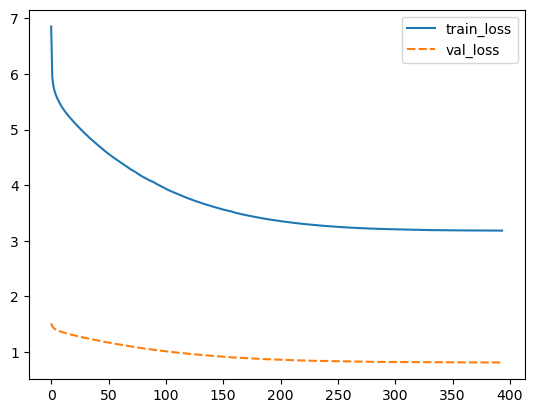

In [13]:
# plot the train and val losses
loss_history = pd.DataFrame({
    "train_loss": train_loss_history,
    "val_loss": val_loss_history
})
sns.lineplot(data=loss_history)

In [14]:
# save model state_dict
torch.save(model.state_dict(), '/mnt/workspace/pratheek/models/saved/model1_biolincc.pth')

### Inference

In [9]:
inf_model = FCN()
inf_model.load_state_dict(torch.load('/mnt/workspace/pratheek/models/saved/model1_biolincc.pth'))
if torch.cuda.is_available():
    inf_model = inf_model.to('cuda')
inf_model.eval()

FCN(
  (first_layer): Linear(in_features=768, out_features=256, bias=True)
  (relu): ReLU()
  (second_layer): Linear(in_features=256, out_features=128, bias=True)
  (cosine): CosineSimilarity()
  (sigmoid): Sigmoid()
)

In [10]:
outputs = []
labels = []
idxs = []

for batch in test_loader:
    idx, inp1, inp2, label = batch
    idx = idx.cpu().squeeze().detach().numpy()
    idxs.append(idx)
    
    if torch.cuda.is_available():
        inp1 = inp1.to('cuda')
        inp2 = inp2.to('cuda')
        label = label.to('cuda')

    output = inf_model(inp1, inp2)
    
    output = output.cpu().squeeze().detach().numpy()
    outputs.append(output)
    label = label.cpu().squeeze().detach().numpy()
    labels.append(label)

idxs = np.concatenate(idxs).ravel()
outputs = np.concatenate(outputs).ravel()
labels = np.concatenate(labels).ravel()

In [11]:
idxs

array([55943, 11013,   168, ..., 58307, 45287, 29899])

In [12]:
outputs

array([0.1973115 , 0.45285705, 0.39216387, ..., 0.45204732, 0.1588917 ,
       0.17003255], dtype=float32)

In [13]:
labels

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [14]:
with open('./visualization/fcn_preds.pkl', 'wb') as wfile:
    pickle.dump(outputs, wfile)
with open('./visualization/fcn_gt_labels.pkl', 'wb') as wfile:
    pickle.dump(labels, wfile)

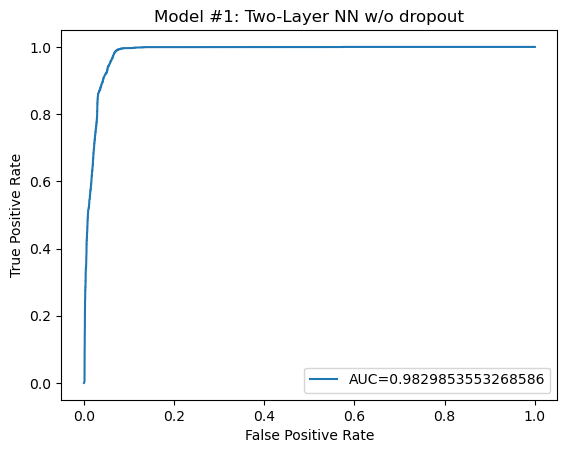

In [15]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(labels, outputs)
auc = metrics.roc_auc_score(labels, outputs)

plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Model #1: Two-Layer NN w/o dropout')
plt.legend(loc=4)
plt.show()

In [16]:
# CI AUC
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = outputs
y_test = labels
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = metrics.roc_auc_score(pd.DataFrame(y_test).iloc[indices][0].values, pd.DataFrame(y_pred).iloc[indices][0].values)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([0.98107877, 0.98504733])

In [16]:
inf_df = df_test[df_test['idx'].isin(idxs)]
inf_preds = pd.DataFrame({
    "idx": idxs,
    "match": labels,
    "predict_proba": outputs
})
inf_df = inf_df.merge(inf_preds, on=['idx', 'match'], how='inner')
inf_df.head()

,idx,variable_description_1,concept_name_1,study_1,variable_description_2,concept_name_2,study_2,match,biobert_embedding_1,biobert_embedding_2,predict_proba
0,1,Atrial fibrillation,AFIB,ARIC,time to incident af,AFIB,ARIC,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.2017), tensor(-0.1166), tensor(-0.38...",0.450044
1,3,Atrial fibrillation,AFIB,ARIC,ATRIAL FIBRILLATION,AFIB,Framingham,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.1640), tensor(0.1292), tensor(0.2356...",0.453111
2,6,Atrial fibrillation,AFIB,ARIC,ECG-ATRIAL FIBRILLATION,AFIB,Framingham,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.3071), tensor(-0.1571), tensor(0.261...",0.424891
3,11,Atrial fibrillation,AFIB,ARIC,Atrial Fibrillation (via ICD10 Code): Time fro...,AFIB,MESA,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.3229), tensor(-0.1879), tensor(0.095...",0.446989
4,16,Atrial fibrillation,AFIB,ARIC,"TIME BETWEEN FIRST AND FIFTH VISITS, IN DAYS",AFIB,MESA,1,"[tensor(0.1640), tensor(0.1292), tensor(0.2356...","[tensor(0.3109), tensor(-0.0889), tensor(-0.12...",0.372877


In [17]:
# per-concept AUC
concepts = inf_df.concept_name_1.unique()
pc_aucs = []
mauc_ovr = {}
for concept in concepts:
    print("------------------------")
    
    inf_df_concept = inf_df[(inf_df['concept_name_1'] == concept) | (inf_df['concept_name_2'] == concept)]
    print(concept, ": ", inf_df_concept.shape[0])
    
    preds = inf_df_concept.predict_proba.to_list()

    gt_labels = inf_df_concept.match.to_list()
    
    if len(inf_df_concept.match.unique()) == 1:
        print("Only single class present")
        continue
    fpr, tpr, _ = metrics.roc_curve(gt_labels, preds)
    mauc_ovr[concept] = metrics.roc_auc_score(gt_labels, preds)
    pc_aucs.append(metrics.roc_auc_score(gt_labels, preds))
    print("AUC for", concept, " : ", mauc_ovr[concept])

------------------------
AFIB :  318
AUC for AFIB  :  0.9307166528583265
------------------------
AGE :  321
AUC for AGE  :  1.0
------------------------
ALCOHOL :  250
AUC for ALCOHOL  :  1.0
------------------------
ANYCHOLMED :  1181
AUC for ANYCHOLMED  :  0.9646209002922764
------------------------
ASPIRIN :  439
AUC for ASPIRIN  :  0.8944767690596388
------------------------
BASE_CVD :  92
AUC for BASE_CVD  :  0.888888888888889
------------------------
BASE_STROKE :  84
AUC for BASE_STROKE  :  0.9875
------------------------
BG :  135
AUC for BG  :  1.0
------------------------
BMI :  238
AUC for BMI  :  1.0
------------------------
CARSTEN :  116
AUC for CARSTEN  :  1.0
------------------------
CENSDAY :  51
AUC for CENSDAY  :  0.9652777777777778
------------------------
CREAT :  183
AUC for CREAT  :  1.0
------------------------
CURRSMK :  341
AUC for CURRSMK  :  1.0
------------------------
DEATH_IND :  50
AUC for DEATH_IND  :  0.9591836734693877
------------------------
DIAB :

In [18]:
pd.DataFrame(pc_aucs).describe()

,0
count,56.000000
mean,0.971258
std,0.061107
min,0.629630
25%,0.964175
50%,0.995079
75%,1.000000
max,1.000000


In [19]:
with open('./visualization/fcn_mauc_ovr.pkl', 'wb') as wfile:
    pickle.dump(mauc_ovr, wfile)

In [20]:
concept = 'AFIB'
conc_inf_df = inf_df[(inf_df['concept_name_1'] == concept) | (inf_df['concept_name_2'] == concept)][['variable_description_1', 'concept_name_1', 'variable_description_2', 'concept_name_2', 'match', 'predict_proba']]
conc_inf_df

,variable_description_1,concept_name_1,variable_description_2,concept_name_2,match,predict_proba
0,Atrial fibrillation,AFIB,time to incident af,AFIB,1,0.450044
1,Atrial fibrillation,AFIB,ATRIAL FIBRILLATION,AFIB,1,0.453111
2,Atrial fibrillation,AFIB,ECG-ATRIAL FIBRILLATION,AFIB,1,0.424891
3,Atrial fibrillation,AFIB,Atrial Fibrillation (via ICD10 Code): Time fro...,AFIB,1,0.446989
4,Atrial fibrillation,AFIB,"TIME BETWEEN FIRST AND FIFTH VISITS, IN DAYS",AFIB,1,0.372877
...,...,...,...,...,...,...
11681,YAMS/SWEET POTATOES:(servings/week),VEGETABLES,"Time between first and third visits, in days",AFIB,0,0.200616
11693,GREEN STRING BEANS OR ASPARAGUS,VEGETABLES,Atrial fibrillation,AFIB,0,0.210589
11737,WINTER SQUASH:(servings/week),VEGETABLES,Atrial fibrillation,AFIB,0,0.206622
11849,"Weight (pounds), Exam 1",WGT,ATRIAL FIBRILLATION,AFIB,0,0.240668


In [21]:
proba_1 = inf_df.loc[inf_df['match'] == 1, 'predict_proba'].to_numpy()
proba_1.sort()
proba_0 = inf_df.loc[inf_df['match'] == 0, 'predict_proba'].to_numpy()
proba_0.sort()

In [22]:
with open('./visualization/fcn_prob_match_0.pkl', 'wb') as wfile:
    pickle.dump(proba_0, wfile)
with open('./visualization/fcn_prob_match_1.pkl', 'wb') as wfile:
    pickle.dump(proba_1, wfile)

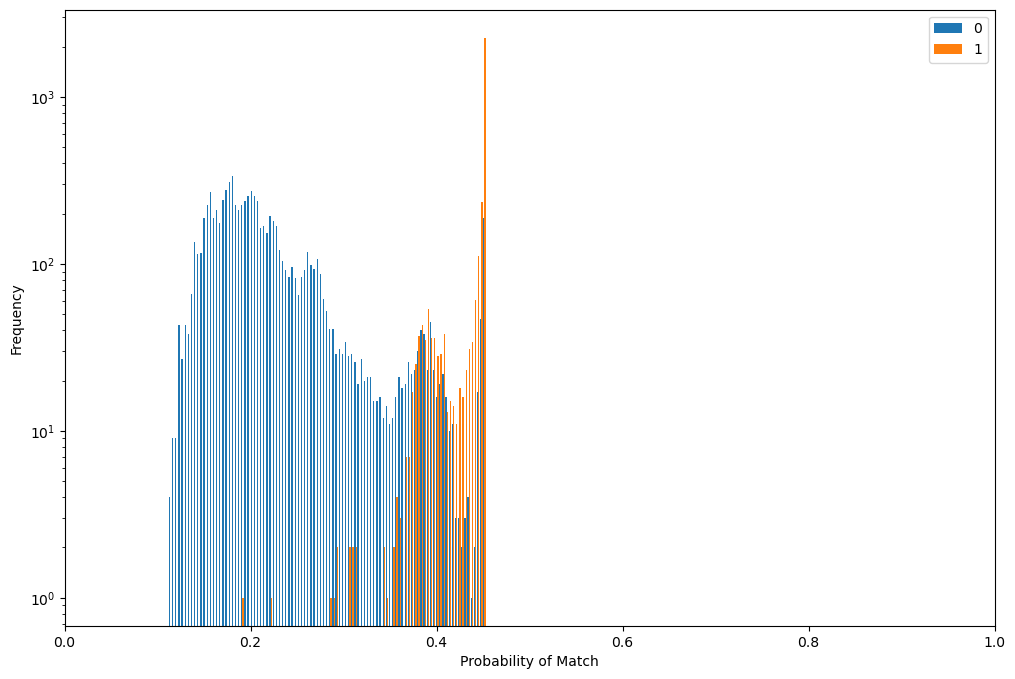

In [23]:
# plot prediction probabilities
plt.figure(figsize=(12,8))
plt.hist([proba_0, proba_1], bins=101, label=['0', '1'])
plt.legend(loc="upper right")
plt.xlabel("Probability of Match")
plt.ylabel("Frequency")
plt.yscale('log')
plt.xlim(0.0, 1.0)
# plt.ylim(0, 1800)
plt.show()

In [24]:
violin_concepts = []
violin_match = []
violin_pred = []

In [25]:
for concept in concepts:
    match_inf_conc = inf_df[(inf_df['concept_name_1'] == concept) | (inf_df['concept_name_2'] == concept)][['concept_name_1','concept_name_2', 'match', 'predict_proba']]
    match_inf_conc['concept_name'] = match_inf_conc['concept_name_1'] + "," + match_inf_conc['concept_name_2']
    match_inf_conc['concept_name'] = match_inf_conc['concept_name'].str.split(",")
    match_inf_conc = match_inf_conc.explode('concept_name')
    match_inf_conc = match_inf_conc.drop(columns=['concept_name_1', 'concept_name_2'])
    match_inf_conc = match_inf_conc.drop_duplicates().reset_index(drop=True)
    violin_concepts.append(match_inf_conc['concept_name'].values)
    violin_match.append(match_inf_conc['match'].values)
    violin_pred.append(match_inf_conc['predict_proba'].values)

In [26]:
violin_df = pd.DataFrame({
    "concept": np.concatenate(violin_concepts).tolist(),
    "match": np.concatenate(violin_match).tolist(),
    "predict_proba": np.concatenate(violin_pred).tolist()
})
print(violin_df.shape)
violin_df = violin_df.sort_values("concept")

(37161, 3)


In [27]:
violin_df.to_pickle('./visualization/fcn_violin_df.pkl')

<AxesSubplot:xlabel='predict_proba', ylabel='concept'>

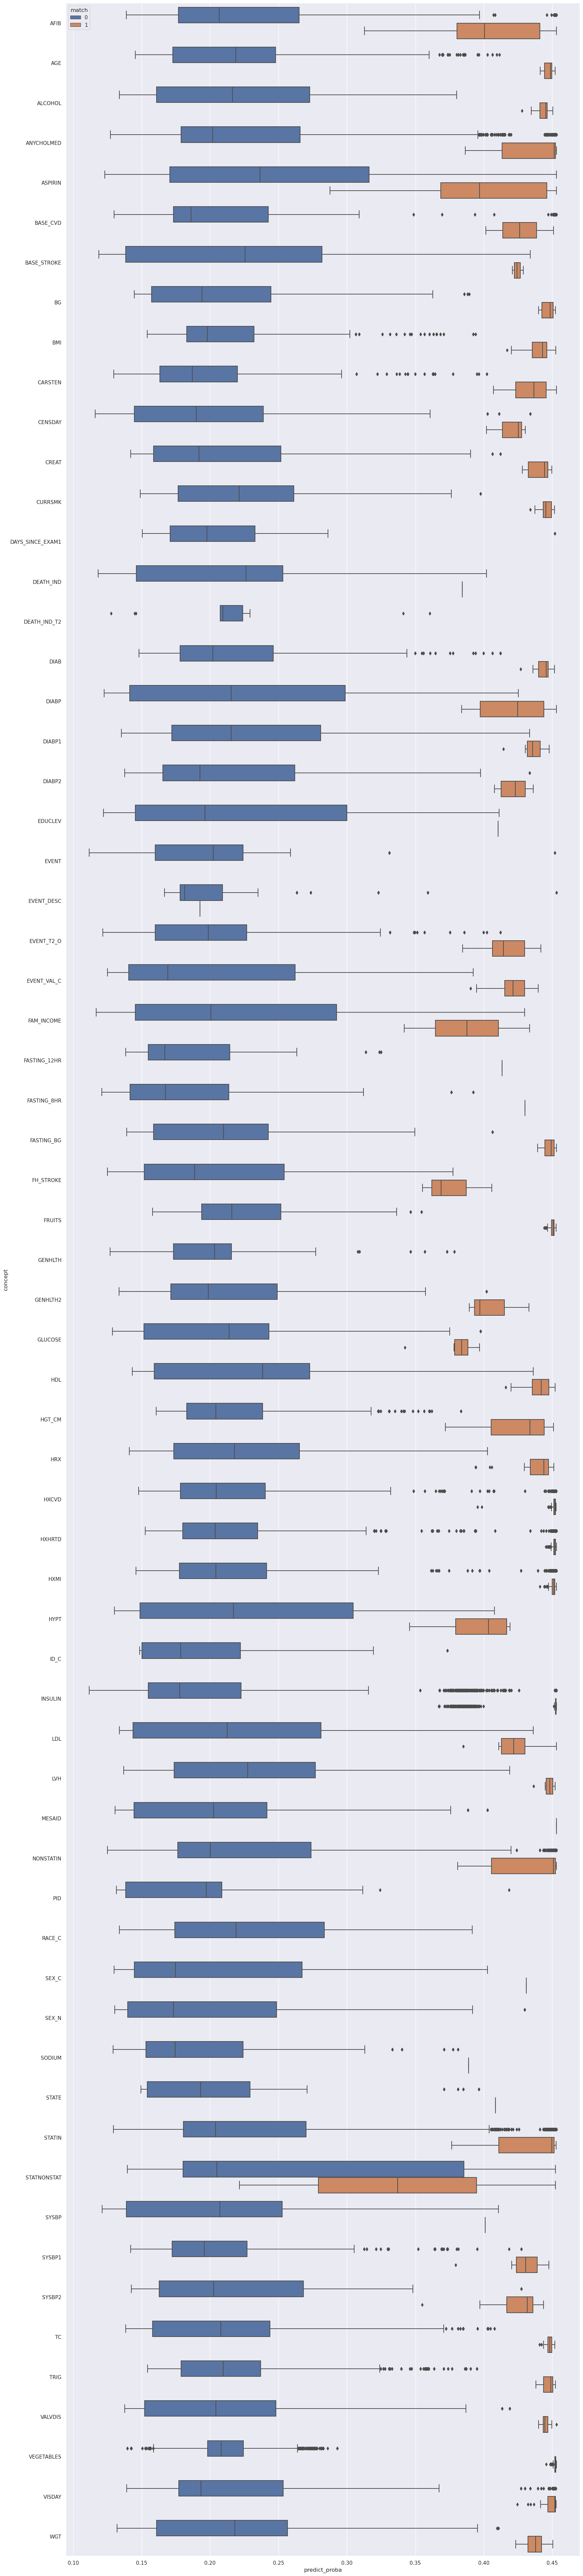

In [28]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 100)})
sns.boxplot(data=violin_df, x="predict_proba", y="concept", hue="match")

### Concept Predictor

In [29]:
df_p = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/predictor_data_biolincc.pkl")
df_p = df_p.reset_index(drop=True)
df_p

,variable_description,concept,study,biobert_embedding
0,Atrial fibrillation,AFIB,ARIC,"[tensor(0.1640), tensor(0.1292), tensor(0.2356..."
1,Incident AF,AFIB,ARIC,"[tensor(-0.0823), tensor(-0.1281), tensor(-0.3..."
2,time to incident af,AFIB,ARIC,"[tensor(0.2017), tensor(-0.1166), tensor(-0.38..."
3,DAYS SINCE EXAM 1,AFIB,ARIC,"[tensor(0.4667), tensor(-0.3528), tensor(-0.15..."
4,ATRIAL FIBRILLATION,AFIB,Framingham,"[tensor(0.1640), tensor(0.1292), tensor(0.2356..."
...,...,...,...,...
942,TRIG,TRIG,None,"[tensor(0.1032), tensor(0.0132), tensor(0.0905..."
943,VALVDIS,VALVDIS,None,"[tensor(0.4729), tensor(-0.0575), tensor(-0.09..."
944,VEGETABLES,VEGETABLES,None,"[tensor(0.3033), tensor(-0.2493), tensor(-0.44..."
945,VISDAY,VISDAY,None,"[tensor(0.2013), tensor(-0.2242), tensor(-0.23..."


In [30]:
# prepare the predictor dataset
df_p_dict = {}
p_concepts = df_p[df_p['study'] == 'None']['concept'].values
p_concepts_embeds = df_p[df_p['study'] == 'None']['biobert_embedding'].values

In [31]:
p_var_desc = df_p.iloc[0, 0]
p_var_concept = df_p.iloc[0, 1]
p_var_embed = df_p.iloc[0, 3]
p_var_input1 = torch.tensor([p_var_embed.numpy() for i in range(len(p_concepts_embeds))])
p_var_input2 = torch.tensor([p_concept_embed.numpy() for p_concept_embed in p_concepts_embeds])
p_var_target = torch.tensor(pd.Series(p_concepts).str.contains(p_var_concept).astype('int').to_numpy())
df_p_dict[p_var_desc] = (p_var_input1, p_var_input2, p_var_target)

In [32]:
p_pred_score = inf_model(df_p_dict[p_var_desc][0].to('cuda'), df_p_dict[p_var_desc][1].to('cuda')).cpu().squeeze().detach().numpy()
p_pred_df = pd.DataFrame({
    'concept_name': p_concepts,
    'pred_score': p_pred_score
}).sort_values(by=['pred_score'], ascending=False)
p_pred_df.head(5)

,concept_name,pred_score
0,AFIB,0.445995
60,VISDAY,0.398522
37,HXHRTD,0.366048
36,HXCVD,0.365807
38,HXMI,0.365176


In [33]:
df_p = df_p.drop_duplicates(subset=['variable_description'])
df_p.shape

(793, 4)

In [34]:
# prepare a custom function for prediction given a sentence
# ensure protobuf = 3.20.x
from biobert_embedding.embedding import BiobertEmbedding
biobert = BiobertEmbedding(model_path='/mnt/workspace/pratheek/packages/biobert/')

class ConceptPredictor:
    def __init__(self, model, concepts, concepts_embeds):
        self.model = model
        self.concepts = concepts
        self.concepts_embeds = concepts_embeds
    
    def predict_concept(self, sentence):
        sent_embed = biobert.sentence_vector(sentence)
        input1 = torch.tensor([sent_embed.numpy() for i in range(len(self.concepts_embeds))])
        input2 = torch.tensor([concept_embed.numpy() for concept_embed in self.concepts_embeds])
        pred_score = self.model(input1.to('cuda'), input2.to('cuda')).cpu().squeeze().detach().numpy()
        pred_df = pd.DataFrame({
            'concept_name': self.concepts,
            'pred_score': pred_score
        }).sort_values(by=['pred_score'], ascending=False)

        return pred_df
    
    def baseline(self, sentence):
        sent_embed = biobert.sentence_vector(sentence)
        input1 = [sent_embed for i in range(len(self.concepts_embeds))]
        input2 = [concept_embed for concept_embed in self.concepts_embeds]
        cos_sim = nn.CosineSimilarity(dim=0)
        pred_df = pd.DataFrame({
            'concept_name': self.concepts,
            'biobert_embedding_1': input1,
            'biobert_embedding_2': input2
        })
        pred_df['cosine_similarity'] = pred_df.apply(lambda x: cos_sim(x.biobert_embedding_1, x.biobert_embedding_2).numpy(), axis=1)
        pred_df = pred_df.drop(columns=['biobert_embedding_1', 'biobert_embedding_2']).sort_values(by=['cosine_similarity'], ascending=False)
        
        return pred_df

2024-04-29 00:45:57.779556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 00:45:58.711596: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64/
2024-04-29 00:45:58.711727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64/
2024-04-29 00:45:58.711740: W tensorflow/compiler/tf2tensorrt/utils/py_u

In [35]:
CPred = ConceptPredictor(inf_model, p_concepts, p_concepts_embeds)

In [36]:
tmp1 = CPred.predict_concept("ECG: RHYTHM")
tmp1

,concept_name,pred_score
4,BASE_CVD,0.407746
1,ALCOHOL,0.392056
60,VISDAY,0.376449
0,AFIB,0.374455
19,EDUCLEV,0.369593
...,...,...
34,HGT_CM,0.225264
2,ANYCHOLMED,0.209618
51,STATIN,0.203938
3,ASPIRIN,0.185780


In [37]:
tmp1 = CPred.baseline("ECG: RHYTHM")
tmp1

,concept_name,cosine_similarity
11,CURRSMK,0.85236317
36,HXCVD,0.85200137
27,FASTING_BG,0.8453882
18,DIABP2,0.84490925
26,FASTING_8HR,0.8438038
...,...,...
32,GLUCOSE,0.71754974
1,ALCOHOL,0.71450764
29,FRUITS,0.71361685
59,VEGETABLES,0.6829248


In [42]:
# get the top1 and top5 accuracy
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [43]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  63.9344
top5 accuracy:  80.454


In [44]:
# CI top-1
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top1
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([60.5296   , 67.3423525])

In [45]:
# CI top-5
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
y_pred = top5
y_test = pd.DataFrame([True for i in range(len(y_pred))])
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))

    score = np.round(sum(pd.DataFrame(y_pred).iloc[indices][0].values) / sum(y_test.iloc[indices][0].values) * 100, 4)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
np.percentile(bootstrapped_scores, (2.5, 97.5))

array([77.4275, 83.2282])

In [40]:
# get the top1 and top5 accuracy (baseline)
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.baseline(row['variable_description'])
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [41]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  13.1148
top5 accuracy:  22.8247
